Orginal Data: 
                           Title              Category  Rating  \
0     Dairy Queen Grill & Chill  Fast food restaurant     3.8   
1             Jake's Restaurant   American restaurant     4.4   
2                 Carib Kitchen  Caribbean restaurant     4.9   
3  Cazadores Mexican Restaurant    Mexican restaurant     4.5   
4       La Posada Mexican Grill    Mexican restaurant     4.3   

                                             Address  \
0  Dairy Queen Grill & Chill, 3143 US-280, Alexan...   
1  Jake's Restaurant, 16 Broad St, Alexander City...   
2  Carib Kitchen, 68 Broad St, Alexander City, AL...   
3  Cazadores Mexican Restaurant, 910 Cherokee Rd,...   
4  La Posada Mexican Grill, 3714 US-280, Alexande...   

                                          Categories   ZCTA         NAME  \
0         ['Fast food restaurant', 'Ice cream shop']  35010  ZCTA5 35010   
1                            ['American restaurant']  35010  ZCTA5 35010   
2                           

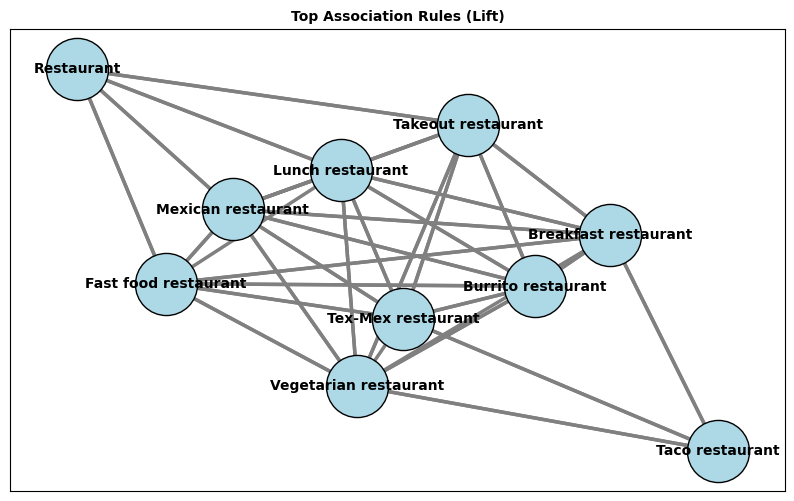

In [3]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/merged_restaurants_census.csv")
print("Orginal Data: \n",df.head(),"\n")

df['Categories'] = df['Categories'].apply(lambda x: eval(x) if isinstance(x, str) else [])
transactions = df['Categories'].tolist()
transactions_df = pd.DataFrame({'Transactions': transactions})
transactions_df.to_csv("transactions_data.csv", index=False)
print("Unlabeled Transaction Data: \n",transactions_df.head(),"\n")

# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori algorithm
min_support = 0.005  # Adjust threshold as needed
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Extract top 15 rules based on support, confidence, and lift
top_support = rules.nlargest(15, 'support')
top_confidence = rules.nlargest(15, 'confidence')
top_lift = rules.nlargest(15, 'lift')

# Display top rules
print("Top 15 Rules by Support:\n", top_support,"\n")
print("Top 15 Rules by Confidence:\n", top_confidence,"\n")
print("Top 15 Rules by Lift:\n", top_lift,"\n")

# Visualization: Network Graph
def draw_network(rules_df, title):
    G = nx.DiGraph()
    for _, row in rules_df.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(antecedent, consequent, weight=row['lift'])

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    edges = G.edges(data=True)
    weights = [edata['weight'] for _, _, edata in edges]

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000, edgecolors='black')

    # Draw edges with increased thickness and darker color
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=[(w / max(weights) * 2) + 0.5 for w in weights],
                            edge_color='grey', arrows=True, arrowsize=20)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black',font_weight='bold')

    plt.title(title, fontsize=10,fontweight='bold')
    plt.show()

# Draw network for top lift rules
draw_network(top_lift, "Top Association Rules (Lift)")